<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2022

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 3 <br>
American Sign Language Image Classification
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
			<br/><br/>
Deadline:  
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
<br>
<font size=3 color=grey>
Author: Sayeh Jarollahi
</font>
                <br/>
    </div>

In [375]:
# Set your student number
student_number = 99102123
Name = 'Hossein'
Last_Name = 'Goli'

In this question, you will train a neural network for classifying sign language images. The American  Sign Language (ASL) dataset consists of 2515 images from different numbers and alphabets. The images are in RGB format and are not the same size. The dataset is classified into 36 classes (10 numbers and 26 alphabets). 

You will need to train a model to classify this dataset into different categories. You are allowed to use MLP as well as CNN networks. 

**Grading Policy:** For a full mark on this assignment, your notebook should be completely runnable by the TA. Additionally, you must reach an accuracy of %96 on the test data.

It is highly recommended to use google colab and utilize its GPUs. However, if you want to run the notebook locally, you can reach and download the dataset in this [link](https://drive.google.com/file/d/11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5/view?usp=share_link).



## Setup


In [376]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os

from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from q1_helper_code import get_files

#########################################
#                                       #
#  import other necessery packages here #
#                                       #
#########################################
import torchvision.transforms as T

In [377]:
# NOTE: It is highly recommended to use colab GPUs!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Download and unzip the dataset


In [378]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5" -O asl_dataset.zip && rm -rf /tmp/cookies.txt
! unzip asl_dataset.zip


--2023-01-30 13:29:47--  https://docs.google.com/uc?export=download&confirm=t&id=11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5
Resolving docs.google.com (docs.google.com)... 172.253.122.100, 172.253.122.139, 172.253.122.102, ...
Connecting to docs.google.com (docs.google.com)|172.253.122.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1dl3h5k35t34dcna1hta6bqjjjdjutb8/1675085325000/05091738964991961299/*/11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5?e=download&uuid=d8c100b3-b7cc-4d72-a3e8-fda0f782879a [following]
--2023-01-30 13:29:47--  https://doc-0o-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1dl3h5k35t34dcna1hta6bqjjjdjutb8/1675085325000/05091738964991961299/*/11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5?e=download&uuid=d8c100b3-b7cc-4d72-a3e8-fda0f782879a
Resolving doc-0o-bc-docs.googleusercontent.com (doc-0o-bc-docs.googleusercontent.com)... 142.250.31.1

In [379]:
main_dir = "asl_dataset/asl_dataset"
class_dirs = os.listdir(main_dir)

In [380]:
img = imread(main_dir + "/" + class_dirs[0] + "/" + os.listdir(main_dir + "/" + class_dirs[0])[0])

## Transform 

Data transformation is the process of converting data from one format or structure into another format or structure. Transformers change pixel values but still keep almost the whole information of the image.[source](https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4) You can read more about them in the mentioned source. 

You are going to implement two different transformers from scratch. These transformers will be used once the data is loaded. 

### Resize 
This transformer recieves a tensor (3\*x\*y) and returns a tensor with shape (3\*size\*size)

In [381]:
class Resize(object):
    
    def __init__(self, size=50):
        self.size = size        
  
    def __call__(self, x):
        '''
        This function recieves a tensor and applies the resizing on that and returns that tensor
        '''
        return T.Resize(size= self.size)(x)

### GrayScale
This transform is helpful to decrease the number of channels, so the training gets faster. 

Feel free to add args to functions or change them if you need to!

In [382]:
class GrayScale(object):

    def __init__(self):
        pass

    def __call__(self, x):
      x = T.Grayscale()(x)
      return x

## Load Data and compose transforms 
You can combine Transforms using the **compose** method in the torchvision.transforms library.

In [383]:
# Ddd the implemented transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    Resize(),
    GrayScale()
])

Plot one random sample from each class of the datset:

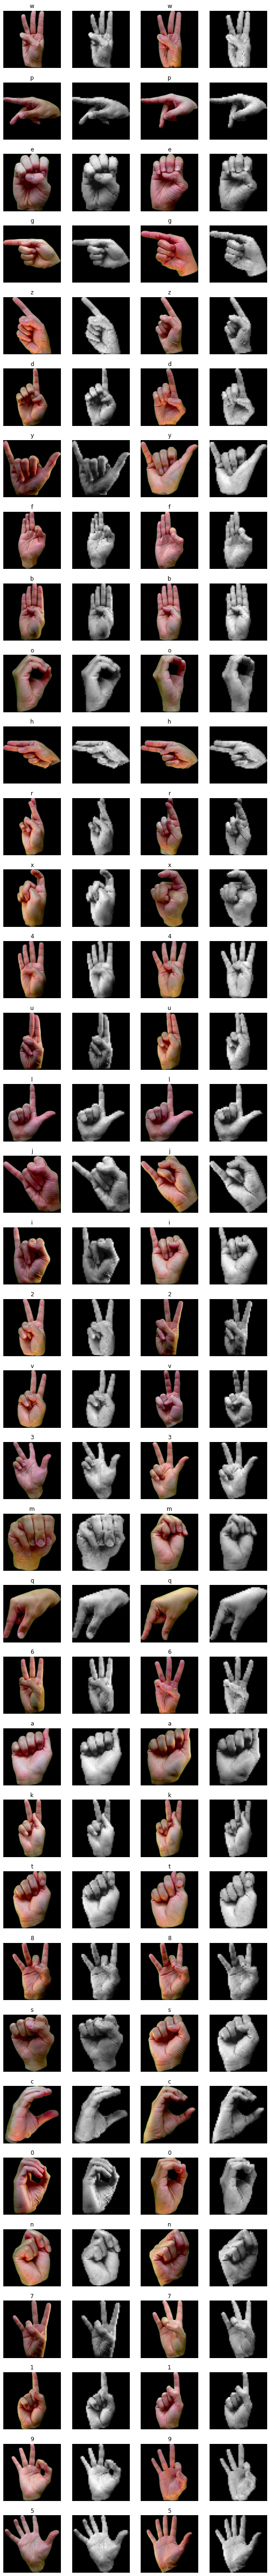

In [384]:
'''
Hint:
Get two random samples from files in each directory and use subplot to add those
images to the plot. 
Use previously defined transform to test your transforms
'''

#there are 36 classes and each row has 2 images
fig, ax = plt.subplots(36, 4, figsize=(10, 100))

for i in range(36):
    for j in range(2):
        if j == 1:
            j = 2
        img = imread(main_dir + "/" + class_dirs[i] + "/" + os.listdir(main_dir + "/" + class_dirs[i])[j])
        ax[i][j].imshow(img)
        ax[i][j].axis('off')
        ax[i][j].set_title(class_dirs[i])
        transformed_img = transform(img)
        ax[i][j + 1].imshow(transformed_img.squeeze(), cmap='gray')
        ax[i][j + 1].axis('off')

    

## Create Dataset 
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. [from [Pytorch Documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)] 

In this section, you will implement a custom dataset which gets address of files and loads them as needed. 

In [385]:
class ASLDataset(Dataset):
    def __init__(self, files_address:list, transform=transform):
        #############################
        #         Code here         #
        #############################
        self.files_address = files_address
        self.transform = transform
        self.char_to_idx = {}
        self.idx_to_char = {}
        for i in range(len(class_dirs)):
            self.idx_to_char[i] = class_dirs[i]
            self.char_to_idx[class_dirs[i]] = i



    def __len__(self):
        # returns length of the data

        #############################
        #         Code here         #
        #############################
        #each file adress has multiple images
        return len(self.files_address)



    def __getitem__(self, idx):
        # Hint: load image from files_address and the label from name of the directory 
        # Remember to apply transforms!
        image = imread(self.files_address[idx])
        label = self.files_address[idx].split('/')[-2]
        label_tensor = torch.zeros(num_classes)
        label_tensor[self.char_to_idx[label]] = 1
        image = self.transform(image)
        #############################
        #         Code here         #
        #############################
        return image, label_tensor

In [386]:
files_addr, labels = get_files()
print(len(labels), len(files_addr))

2515 2515


## Create Datasets  

First split data to train, validation and test using the `train_test_split funciton`. Remember to shuffle data. Then create ASLDataset for each part of data. 

In [387]:
#############################
#         Code here         #
#############################
x_train, x_test, y_train, y_test = train_test_split(files_addr, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

train_dataset = ASLDataset(x_train)
val_dataset = ASLDataset(x_val)
test_dataset = ASLDataset(x_test)


Use datasets to create DataLoader from `torch.utils.DataLoader` class

Note: You should make `shuffle=True` for the training dataLoader, so in each epoch the data reshuffles. 

In [388]:
num_threads = 4

#############################
#         Code here         #
#############################
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=num_threads)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=num_threads)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Define Model 

In [389]:
class ASLModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            #############################
            #         Code here         #
            #############################
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(4608, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, xb):
        #############################
        #         Code here         #
        #############################
        return self.network(xb)


In [390]:
in_channels = 1
num_classes = 36
model = ASLModel(in_channels, num_classes).to(device)

## Define optimizer, Criterion and other parameters 


In [391]:
#############################
#         Code here         #
#############################
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [392]:
# Set parameters and hyper parameters
batch_size = 32
learning_rate = 0.001 
input_size = 50

In [393]:
print(class_dirs)

['w', 'p', 'e', 'g', 'z', 'd', 'y', 'f', 'b', 'o', 'h', 'r', 'x', '4', 'u', 'l', 'j', 'i', '2', 'v', '3', 'm', 'q', '6', 'a', 'k', 't', '8', 's', 'c', '0', 'n', '7', '1', '9', '5']


In [394]:
def train_val (model, trainloader, val_loader, f_loss, optimizer, n_epochs, device = device):
    best_model = None
    best_acc = 0
    train_loss_arr, val_loss_arr = [], []
    train_acc_arr, val_acc_arr = [], []  
    for epoch in range(n_epochs):
        train_loss, val_loss = 0, 0
        model.train()
        #############################
        #         Code here         #
        #############################
        ## Hint: Loop throught train_loader, get images with their labels and train the model
        ## Hint 2: To update train_loss inside the loop use "train_loss += batch_loss * batch_size""
        ## Hint 3: To update train_acc get the predicted label of each training data and compare with the real label
        train_acc = 0
        for batch_idx, (data, target) in enumerate(train_loader):
          optimizer.zero_grad()
          data, target = data.to(device), target.to(device)
          output = model(data)
          loss = f_loss(output, target)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0)
          _, preds = torch.max(output, 1)
          train_acc += torch.sum(preds == torch.argmax(target, dim=1)).item() 
    
        model.eval()
        #############################
        #         Code here         #
        #############################
        ## Hint: Loop throught val_loader, get images with their labels and evaluate the model
        ## Hint 2: To update val_loss inside the loop use "val_loss += batch_loss * batch_size""
        ## Hint 3: you have to keep the best model in the best_model variable to use it in the testing phase
        with torch.no_grad():
          val_acc = 0
          for batch_idx, (data, target) in enumerate(val_loader):
              data, target = data.to(device), target.to(device)
              output = model(data)
              loss = f_loss(output, target)
              val_loss += loss.item() * data.size(0)
              _, preds = torch.max(output, 1)
              val_acc += torch.sum(preds == torch.argmax(target, dim=1)).item()
          
          train_loss /= len(train_loader.dataset)
          val_loss /= len(val_loader.dataset)
          train_loss_arr.append(train_loss)
          val_loss_arr.append(val_loss)
        #############################
        #         Code here         #
        #############################
        # append accuracy of train and valid to the lists
        train_acc = train_acc / len(train_loader.dataset)
        train_acc_arr.append(train_acc)
        val_acc /= len(val_loader.dataset)
        val_acc_arr.append(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model

        print(f"[Epoch {epoch}]\t"
            f"Train Loss: {train_loss:.3f}\t"
            f"Validation Loss: {val_loss:.3f}\t"
            f"Train Acc :{train_acc:.3f}\t"
            f"Validation Acc :{val_acc:.3f}")
    return train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr, best_model, best_acc

In [395]:
# Call the train_val function
train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr, best_model, best_acc = train_val(model, train_loader, val_loader, loss, optimizer, 30)

[Epoch 0]	Train Loss: 2.153	Validation Loss: 0.827	Train Acc :0.404	Validation Acc :0.734
[Epoch 1]	Train Loss: 0.531	Validation Loss: 0.414	Train Acc :0.818	Validation Acc :0.841
[Epoch 2]	Train Loss: 0.276	Validation Loss: 0.275	Train Acc :0.900	Validation Acc :0.903
[Epoch 3]	Train Loss: 0.159	Validation Loss: 0.202	Train Acc :0.933	Validation Acc :0.935
[Epoch 4]	Train Loss: 0.192	Validation Loss: 0.183	Train Acc :0.936	Validation Acc :0.923
[Epoch 5]	Train Loss: 0.128	Validation Loss: 0.213	Train Acc :0.953	Validation Acc :0.918
[Epoch 6]	Train Loss: 0.090	Validation Loss: 0.183	Train Acc :0.969	Validation Acc :0.928
[Epoch 7]	Train Loss: 0.055	Validation Loss: 0.146	Train Acc :0.978	Validation Acc :0.945
[Epoch 8]	Train Loss: 0.046	Validation Loss: 0.123	Train Acc :0.984	Validation Acc :0.963
[Epoch 9]	Train Loss: 0.036	Validation Loss: 0.162	Train Acc :0.985	Validation Acc :0.938
[Epoch 10]	Train Loss: 0.070	Validation Loss: 0.167	Train Acc :0.976	Validation Acc :0.943
[Epoch 11

## Plot loss and accuracy

You must have one plot for loss according to epoch for train/val.

Also, another plot for accuracy according to epoch for train/val

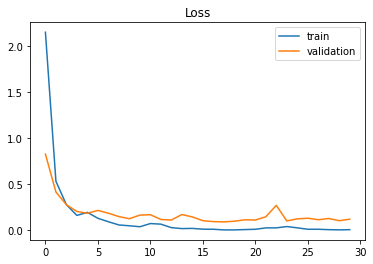

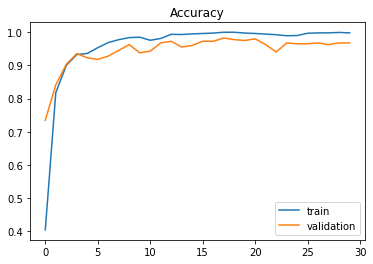

In [400]:
#############################
#         Code here         #
#############################
# Plot the loss and accuracy of train and valid

plt.plot(train_loss_arr, label='train')
plt.plot(val_loss_arr, label='validation')
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(train_acc_arr, label='train')
plt.plot(val_acc_arr, label='validation')
plt.title("Accuracy")
plt.legend()
plt.show()


In [401]:
print(best_acc)

0.9826302729528535


## Evaluate model on the test dataset

Evaluate your best model on the test dataset. You should get accuracy above ***%96*** for a full-mark.

Remember to print the accuracy of model on the test dataset! 

In [403]:
#############################
#         Code here         #
#############################
#############################
#         Code here         #
#############################
# Test the model
test_loss = 0
test_acc = 0
model.eval()
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss_ = loss(output, target)
    test_loss += loss_.item() * data.size(0)
    _, preds = torch.max(output, 1)
    test_acc += torch.sum(preds == torch.argmax(target, dim=1)).item()

test_loss /= len(test_loader.dataset)
test_acc /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.3f}\t"
    f"Test Accuracy: {test_acc * 100:.2f}%")

Test Loss: 0.147	Test Accuracy: 96.62%


some parts that i used copilot for help: the plots(grayscale vs original) - some part of training loop (using max function (it was cool,i didnt know it return max indice too)) 